In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
from spyglass.common import Session, IntervalList, Electrode, get_electrode_indices, interval_list_contains, interval_list_intersect
from spyglass.lfp.v1 import LFPV1
# from spyglass.lfp_band.v1 import LFPBandV1
from spyglass.position import PositionOutput
from spyglass.position.v1 import TrodesPosV1

import os
os.chdir('/home/sambray/Documents/MS_analysis_samsplaying/')
from ms_opto_stim_protocol import OptoStimProtocol,OptoStimProtocolParams, OptoStimProtocolTransfected, OptoStimProtocolLaser, OptoStimProtocolClosedLoop
from Analysis.utils import filter_animal, filter_task
from Analysis.lfp_analysis import get_ref_electrode_index, power_spectrum
from Analysis.position_analysis import filter_position_ports

os.chdir('/home/sambray/Documents/MS_analysis/')
from ms_task_performance import AlternationTaskPerformance
from ms_dio_event import DioEvents, ProcessedDioEvents

from ms_task_identification import TaskIdentification
from ms_interval import EpochIntervalListName

Please enter DataJoint username:  sambray


[2023-08-21 10:35:26,532][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2023-08-21 10:35:26,582][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306


In [3]:
import datajoint as dj

## define trial by first poke times

In [2]:
print(len(((ProcessedDioEvents().LastDownPokes() * EpochIntervalListName) & key).fetch1("dio_last_poke_times")))
print(len(((ProcessedDioEvents().FirstUpPokes() * EpochIntervalListName)& key).fetch1("dio_first_poke_times")))

NameError: name 'key' is not defined

In [29]:
track_type = "wtrack"
inbound_trial = []
trial_durations = []
opto_trial = []
transfected_trial = []
accuracy = []
animal = ""



#################################
for transfected in [True,False]:
    dataset_key = {
                       # 'pulse_length_ms':40,
                       # "transfected":True,
                       "laser_power": 77,
                       'targeted_phase':90,
                        'animal':animal,
                        'transfected':transfected,
                        # "interval_list_name":"pos 3 valid times",
        }
        
    dataset = (OptoStimProtocol *
               OptoStimProtocolTransfected *
               OptoStimProtocolLaser *
               OptoStimProtocolClosedLoop) & dataset_key
    
    dataset = filter_animal(dataset,dataset_key['animal'])
    dataset = filter_task(dataset,track_type)
    
    
    for nwb_file_name,interval_name in zip(dataset.fetch("nwb_file_name"),dataset.fetch("interval_list_name")):
        key = {"nwb_file_name":nwb_file_name,"interval_list_name":interval_name}
        #outcomes and durations
        outcomes = ((AlternationTaskPerformance() * EpochIntervalListName)&key).fetch('performance_outcomes')[0]
        poke_times = ((ProcessedDioEvents().FirstUpPokes() * EpochIntervalListName)& key).fetch1("dio_first_poke_times")
        last_poke_times = ((ProcessedDioEvents().LastDownPokes() * EpochIntervalListName) & key).fetch1("dio_last_poke_times")
        # trial_durations.extend(np.diff(poke_times))
        inbound_trial.extend([('inbound' in x) for x in outcomes[1:]])
        accuracy.extend([('incorrect' in x) for x in outcomes[1:]])
    
        #durations
        travel_intervals = np.array(filter_position_ports(key))
        for i in range(poke_times.size-1):
            travel_ = interval_list_intersect(np.array([[poke_times[i],poke_times[i+1]]]),travel_intervals)
            trial_durations.append(np.sum([interval[1]-interval[0] for interval in travel_]))
        # trial_durations.extend(poke_times[1:]-last_poke_times[:poke_times.size-1])
        
        #Dio intervals
        test_intervals = (OptoStimProtocol() & key).fetch1("test_intervals")
        opto_trial.extend([interval_list_contains(test_intervals,np.array([i])).size for i in poke_times[1:]])

        #transfected
        transfected_trial.extend(np.ones(outcomes.size-1)*int(transfected))

trial_durations = np.array(trial_durations)
inbound_trial = np.array(inbound_trial)
opto_trial = np.array(opto_trial).astype(bool)
transfected_trial = np.array(transfected_trial).astype(bool)
accuracy = ~np.array(accuracy).astype(bool)

wtrack_limit 30.300000000000097
wtrack_limit 28.59999999999952
wtrack_limit 31.199999999999854
wtrack_limit 29.37999999999982
wtrack_limit 32.95
wtrack_limit 30.99999999999994
wtrack_limit 34.30000000000001
wtrack_limit 28.630000000000067
wtrack_limit 32.24999999999994
wtrack_limit 30.759999999999938
wtrack_limit 33.949999999999946
wtrack_limit 29.70999999999985
wtrack_limit 31.749999999999954
wtrack_limit 31.95999999999986
wtrack_limit 32.0499999999999
wtrack_limit 30.639999999999965
wtrack_limit 28.32999999999928
wtrack_limit 26.77000000000004
wtrack_limit 28.330000000000048
wtrack_limit 28.54000000000019
wtrack_limit 30.249999999999773
wtrack_limit 29.649999999999714
wtrack_limit 30.670000000000023
wtrack_limit 27.940000000000055
wtrack_limit 30.519999999999946
wtrack_limit 30.339999999999918
wtrack_limit 27.250000000000046
wtrack_limit 25.719999999999946
wtrack_limit 28.78000000000001
wtrack_limit 27.249999999999943
wtrack_limit 28.270000000000078
wtrack_limit 27.70000000000039
wtr

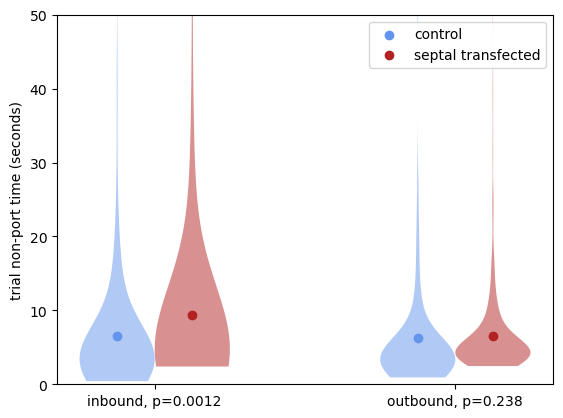

In [32]:
positions = np.array([0,2])
# control = plt.violinplot([trial_durations[inbound_trial & ~transfected_trial& ~accuracy],
#                 trial_durations[~inbound_trial & ~transfected_trial& ~accuracy],],
#                positions = positions,
#                showmedians=False,showextrema=False,points=1000,)
# test = plt.violinplot([trial_durations[inbound_trial & transfected_trial& ~accuracy],
#                 trial_durations[~inbound_trial & transfected_trial& ~accuracy],],
#                positions = positions+.5,
#                showmeans=False,showextrema=False,points=1000,)
# plt.scatter(positions,[np.mean(trial_durations[inbound_trial & ~transfected_trial & ~accuracy]),
#                 np.mean(trial_durations[~inbound_trial & ~transfected_trial& ~accuracy]),],color = 'cornflowerblue',label='control')
# plt.scatter(positions+.5,[np.mean(trial_durations[inbound_trial & transfected_trial& ~accuracy]),
#                 np.mean(trial_durations[~inbound_trial & transfected_trial& ~accuracy]),],color = 'firebrick',label='septal transfected')


control_sets = [trial_durations[inbound_trial & ~transfected_trial & opto_trial],
                trial_durations[~inbound_trial & ~transfected_trial& opto_trial],]
test_sets = [trial_durations[inbound_trial & transfected_trial& opto_trial],
                trial_durations[~inbound_trial & transfected_trial& opto_trial],]
control = plt.violinplot(control_sets,
               positions = positions,
               showmedians=False,showextrema=False,points=1000,)
test = plt.violinplot(test_sets,
               positions = positions+.5,
               showmeans=False,showextrema=False,points=1000,)

plt.scatter(positions,[np.mean(x) for x in control_sets],color = 'cornflowerblue',label='control')
plt.scatter(positions+.5,[np.mean(x) for x in test_sets],color = 'firebrick',label='septal transfected')

from scipy.stats import ttest_ind
inbound_p = ttest_ind(trial_durations[inbound_trial & ~transfected_trial],trial_durations[inbound_trial & transfected_trial],equal_var=False)[1]
outbound_p = ttest_ind(trial_durations[~inbound_trial & ~transfected_trial],trial_durations[~inbound_trial & transfected_trial],equal_var=False)[1]

for pc in control['bodies']:
    pc.set_facecolor('cornflowerblue')
    pc.set_alpha(.5)
for pc in test['bodies']:
    pc.set_facecolor('firebrick')
    pc.set_alpha(.5)
plt.xticks(positions+.25,labels=[f'inbound, p={np.round(inbound_p,4)}',f'outbound, p={np.round(outbound_p,4)}'])
plt.ylabel('trial non-port time (seconds)')
plt.ylim(0,50)

plt.legend()


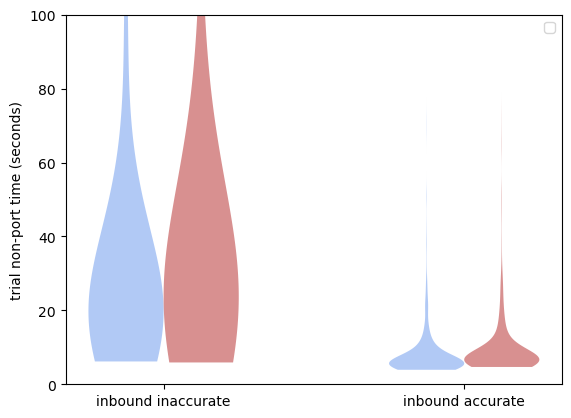

In [202]:
control = plt.violinplot([trial_durations[inbound_trial & ~transfected_trial& ~accuracy],
                trial_durations[inbound_trial & ~transfected_trial& accuracy],],
               positions = positions,
               showmedians=False,showextrema=False,points=1000,)
test = plt.violinplot([trial_durations[inbound_trial & transfected_trial& ~accuracy],
                trial_durations[inbound_trial & transfected_trial& accuracy],],
               positions = positions+.5,
               showmeans=False,showextrema=False,points=1000,)


for pc in control['bodies']:
    pc.set_facecolor('cornflowerblue')
    pc.set_alpha(.5)
for pc in test['bodies']:
    pc.set_facecolor('firebrick')
    pc.set_alpha(.5)

plt.ylim(0,100)
plt.xticks(positions+.25,labels=['inbound inaccurate', 'inbound accurate'])
plt.ylabel('trial non-port time (seconds)')
plt.ylim(0,100)

plt.legend()

In [145]:
from scipy.stats import ttest_ind
inbound_p = ttest_ind(trial_durations[inbound_trial & ~transfected_trial],trial_durations[inbound_trial & transfected_trial],equal_var=False)[1]

outbound_p = ttest_ind(trial_durations[~inbound_trial & ~transfected_trial],trial_durations[~inbound_trial & transfected_trial],equal_var=False)[1]

0.23801773745361235

## Define Trial by running times

In [87]:
animal = "Winnie"
track_type = "wtrack"
dataset_key = {
                   # 'pulse_length_ms':40,
                   # "transfected":True,
                   "laser_power": 77,
                   'targeted_phase':90,
                    'animal':animal,
    }
    
dataset = (OptoStimProtocol *
           OptoStimProtocolTransfected *
           OptoStimProtocolLaser *
           OptoStimProtocolClosedLoop) & dataset_key

dataset = filter_animal(dataset,dataset_key['animal'])
dataset = filter_task(dataset,track_type)

inbound_trial = []
trial_durations = []
opto_trial = []
for nwb_file_name,interval_name in zip(dataset.fetch("nwb_file_name"),dataset.fetch("interval_list_name")):
    key = {"nwb_file_name":nwb_file_name,"interval_list_name":interval_name}
    
    break
interval = (IntervalList & key).fetch1("valid_times")
travel_intervals = np.array(filter_position_ports(key))

wtrack_limit 27.250000000000046


In [89]:
travel_durations = np.array([interval[1]-interval[0] for interval in travel_intervals])
ind = np.where(travel_durations>5)[0]
travel_durations = travel_durations[ind]
travel_intervals = travel_intervals[ind]

In [91]:
travel_durations

array([23.03309441, 13.16654086, 41.66623831, 67.16599464, 13.4665339 ,
        9.16657758, 27.13304543, 26.26641488,  6.69993663, 22.69979262,
       19.76646733,  5.53326893, 23.19978118, 35.86629915, 14.26653147,
       30.03302574, 37.09962034, 17.39983702, 27.99971843, 43.49957609,
        5.39993525, 14.6665144 , 39.93292117, 22.76644826, 32.09968638,
       25.03307891, 33.7996552 , 68.19932914, 15.46650863, 24.29976654,
        5.43326664])